## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [ ]:
import os
import keras
from keras.datasets import cifar10

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
train, test = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


In [ ]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [ ]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [ ]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, regularization, ratio, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    if regularization == "l1":
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(ratio))(x)
    elif regularization == "l2":
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l2(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l2(ratio))(x)
    else:
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1_l2(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1_l2(ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [ ]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
REGULARIZATION = ["l1", "l2", "l1_l2"]
EXP = [1e-2, 1e-4, 1e-8]

In [ ]:
results = {}

for regularization in REGULARIZATION:
    for regulizer_ratio in EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print(f"Regularization: {regularization}, Ratio: {regulizer_ratio}")
        model = build_mlp(input_shape=x_train.shape[1:], regularization=regularization, ratio=regulizer_ratio)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "Regularization: %s, Ratio: %s" % (regularization, str(regulizer_ratio))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Regularization: l1, Ratio: 0.01
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
196/196 [==============================] - 13s 64ms/step - loss: 198.6395 - accuracy: 0.2533 - val_loss: 41.1213 - val_accuracy: 0.2811
Epoch 2/50
196/196 [==============================] - 13s 64ms/step - loss: 19.1296 - accuracy: 0.1190 - val_loss: 7.3057 - val_accuracy: 0.1000
Epoch 3/50
196/196 [==============================] - 14s 74ms/step - loss: 4.1158 - accuracy: 0.0991 - val_loss: 2.6508 - val_accuracy: 0.1000
Epoch 4/50
196/196 [==============================] - 12s 62ms/step - loss: 2.4867 - accuracy: 0.0971 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 5/50
196/196 [==============================] - 13s 64ms/step - loss: 2.4626 - accuracy: 0.0974 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 6/50
196/196 [==============================] - 12s 61ms/step - loss: 2.4626 - accuracy: 0.0952 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 7/50
196/196 [==============================] - 12s 60ms/step - loss: 2.4626 - accuracy: 0.0987 - val_loss: 2.4626 - val_accur

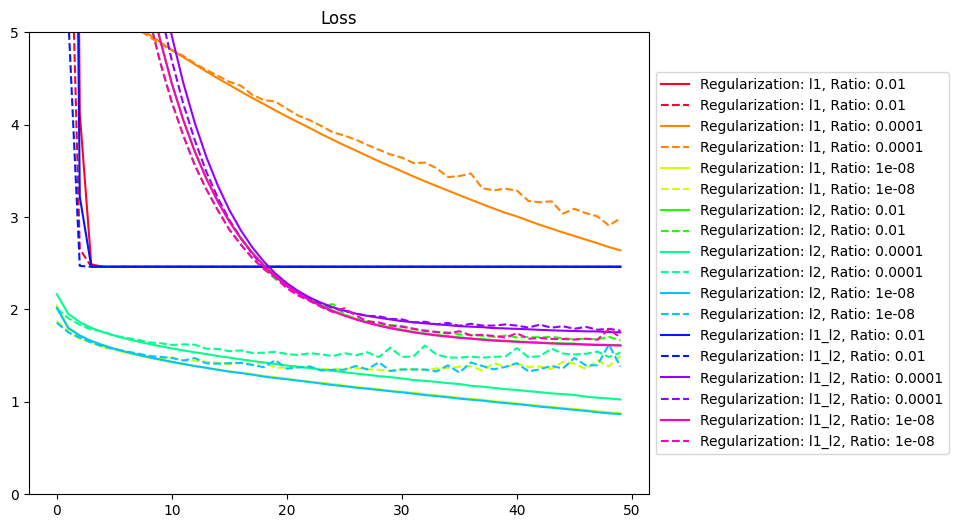

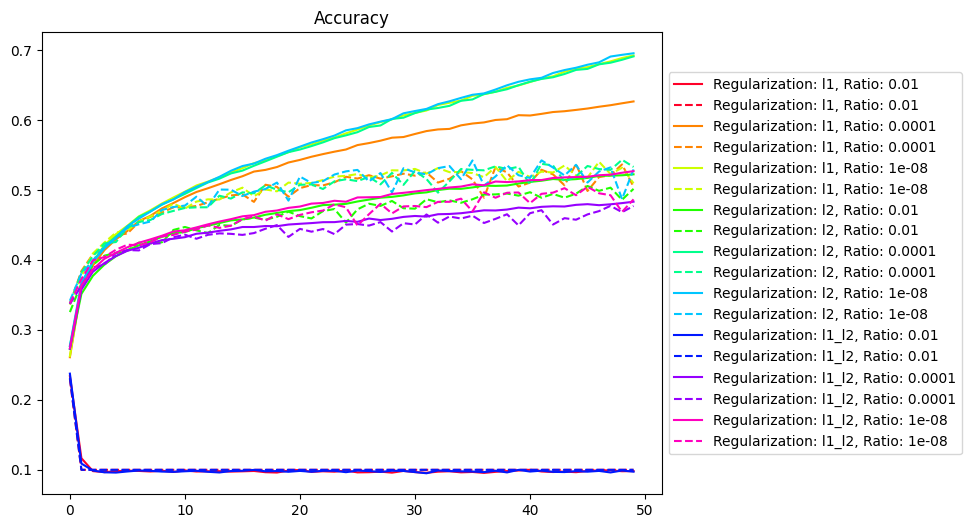

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 9

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()